In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [3]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [4]:
fs = 1000
seed = 8

win=1000
L=25
C=1
emiter=20
K=2

sample_length = win
em_iters = emiter

alpha=350
alpha = float(alpha)
init_type = "flat"
optim_type = "BFGS"

# model_path = f'saved/fitted_models/simple_synthetic_deltarelupoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
# model_path = f'saved/fitted_models/simple_synthetic_deltaidpoisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
# model_load = pickle_open(model_path)


data_path = f'saved/synthetic_data/simple_synthetic_deltarelupoisson_fixed_gamma_{K}_{L}_{sample_length}'
data_load = pickle_open(data_path)
latent = data_load['latent']
xs = latent['xs']
alphas = np.array([alpha for k in range(K)])
lams = cif_alpha_relu(alphas, xs)

Text(0, 0.5, '$\\lambda_t^{k,\\ell}$')

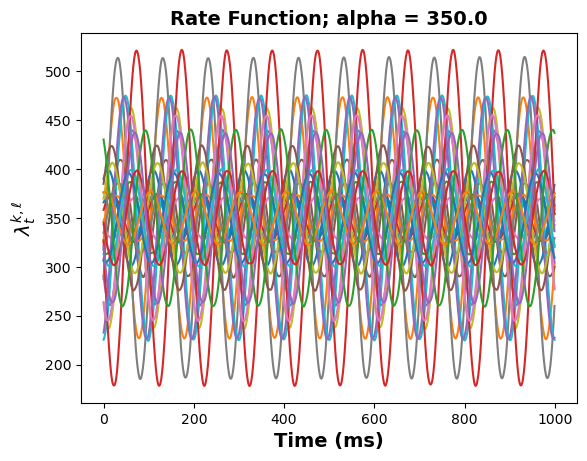

In [4]:
for l in range(L):
    plt.plot(lams[l,0,:])
plt.title(f'Rate Function; alpha = {alpha}', fontweight='bold', fontsize=14)
plt.xlabel('Time (ms)', fontweight='bold', fontsize=14)
plt.ylabel(r'$\lambda_t^{k,\ell}$', fontweight='bold', fontsize=14)

In [5]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, track=None, 
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2
):
    fs = 1000
    delta = 1/fs
    seed = 8
    print()


    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_synthetic_deltarelupoisson_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_relu(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[0,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_vmean_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:50,0,0].real
    S_oracle = Gamma_zest[:50,0,0].real
    S_init = Gamma_init[:50,0,0].real

    S_true = S_true*(delta**2*(2*np.pi)**2)
    S_oracle = S_oracle*(delta**2*(2*np.pi)**2)
    S_init = S_init*(delta**2*(2*np.pi)**2)

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:50]
    coh_true = thr_coherence(Gamma[:50,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:50,:,:])
    coh_init = thr_coherence(Gamma_init[:50,:,:])



    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:50,0,0].real
            S_model_itr = S_model_itr*(delta**2*(2*np.pi)**2)
            coh_model_itr = thr_coherence(Gamma_est_itr[:50,:,:])

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:50,0,0].real
        S_model = S_model*(delta**2*(2*np.pi)**2)
        coh_model = thr_coherence(Gamma_est[:50,:,:])

    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict, spikes=spikes, lams=lams)



In [6]:
def plot_S(alpha_dict, ax, logS=False):
    S_dict = alpha_dict['S']

    S_true = S_dict['true'][:50]
    S_oracle = S_dict['oracle'][:50]
    S_init = S_dict['init'][:50]
    S_naive = S_dict['naive'][:50]

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)

    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    ax.plot(S_oracle, color='tab:green', label='direct')
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = S_dict['model']
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = S_dict['model']
        S_model_list = S_model_list[:track_show]
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=3, alpha=0.8)
        ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

    if logS is True:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([1e4,1e8])

In [47]:
link = "relu"
init_type = "flat"
optim_type = "BFGS"

track = np.array([0,25])
track += 0
track=None

alphas = [200, 350, 400, 500, 600]
# alphas = [6.0]
alpha_fits = []
for alpha in alphas:
    alpha = float(alpha)
    print(alpha)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track)
    alpha_fits.append(alpha_dict)


200.0
350.0
400.0
500.0
600.0


In [52]:
a = np.array([1,2,3,4])
I = np.eye(4)
np.kron(I,a)

array([[1., 2., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 2., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4.]])

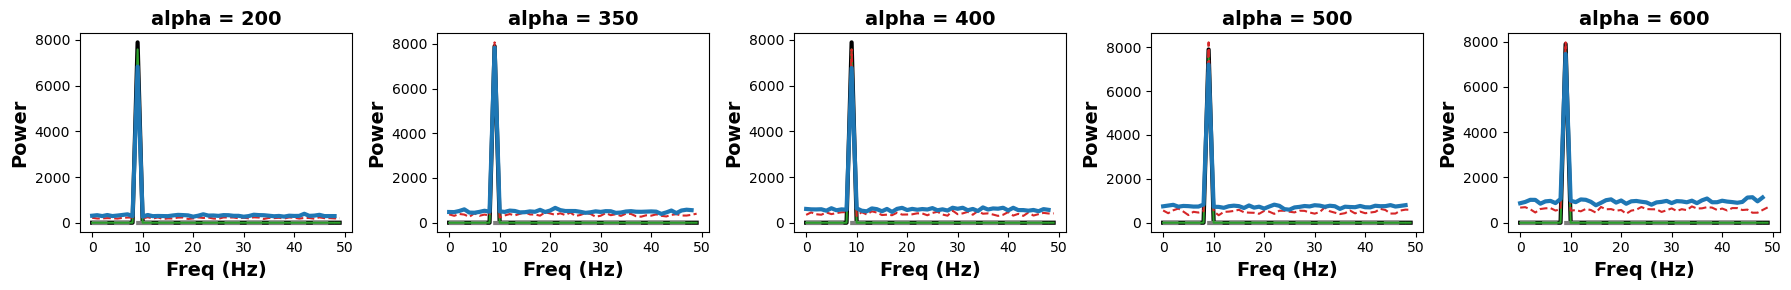

In [48]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    plot_S(alpha_dict,  ax[a], False)
    # ax[a].set_ylim([-65,-5])
plt.tight_layout()

In [43]:
alpha_dict['lams'].shape

(50, 2, 1000)

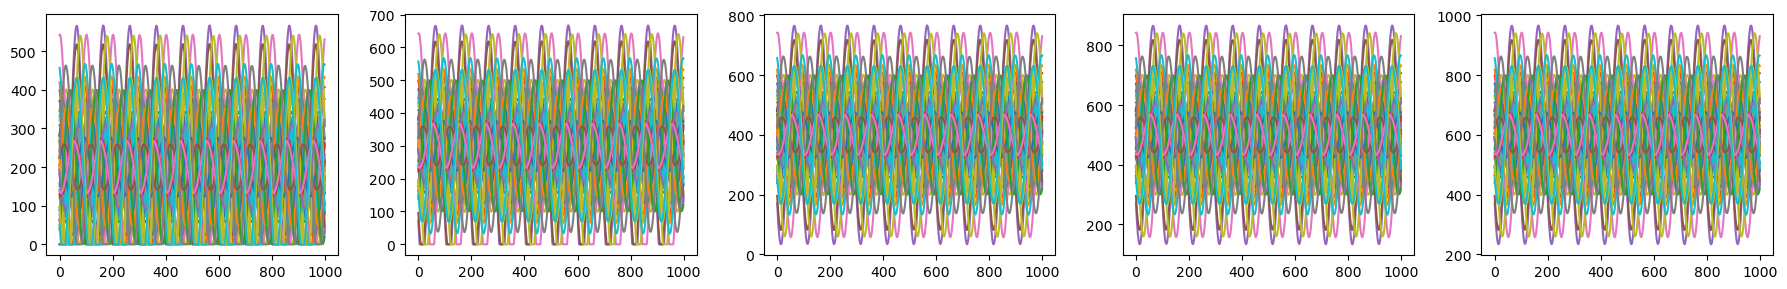

In [45]:
fig, ax = plt.subplots(1,5,figsize=(18,3))
for a, alpha in enumerate(alphas):
    alpha_dict = alpha_fits[a]
    lams = alpha_dict['lams']
    L = lams.shape[0]
    for l in range(L):
        ax[a].plot(lams[l,0,:])
    # ax[a].set_ylim([-65,-5])
plt.tight_layout()

In [7]:
def plot_res_S(link, init_type, optim_type, alpha, logS, track, 
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2
):

    fig, ax = plt.subplots(figsize=(5,3))
    i = 0

    print(alpha)
    track = np.array(track)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track,
                    win=win,
                    L=L,
                    C=C,
                    emiter=emiter,
                    K=2)
    spikes = alpha_dict['spikes']
    S_true = alpha_dict['S']['true']
    S_oracle = alpha_dict['S']['oracle']
    S_naive = alpha_dict['S']['naive']
    S_init = alpha_dict['S']['init']

    S_true = S_true
    S_oracle = S_oracle
    S_init = S_init

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)
    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    # ax.plot(S_oracle, color='tab:green', label='direct')
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = alpha_dict['S']['model']
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = alpha_dict['S']['model']
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        # for i, c in enumerate(color):
        # plt.plot(x, y, c=c)
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=2, alpha=0.8)
        ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

    if logS is False:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([0,3000])

400.0



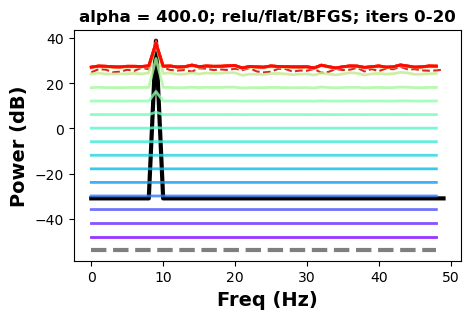

In [18]:
link = 'relu'
init_type = 'flat'
optim_type = 'BFGS'
alpha = 400.0
emiter=20

# get_alpha_data(alpha, link, init_type, optim_type, [17,20], win=1000)
plot_res_S('relu', init_type, optim_type, alpha, True, [0,20], emiter=emiter)
# plt.ylim([0,50])



In [10]:
seed = 8
win=1000
L=50
C=1
emiter=20
K=2
alpha=float(alpha)

sample_length = win
em_iters = emiter


model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_vmean_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

model_load = pickle_open(model_path)

In [11]:
r = 2
model_load['track'][0][r].keys()

dict_keys(['phi', 'gamma', 'inv', 'mus', 'Ups_invs'])

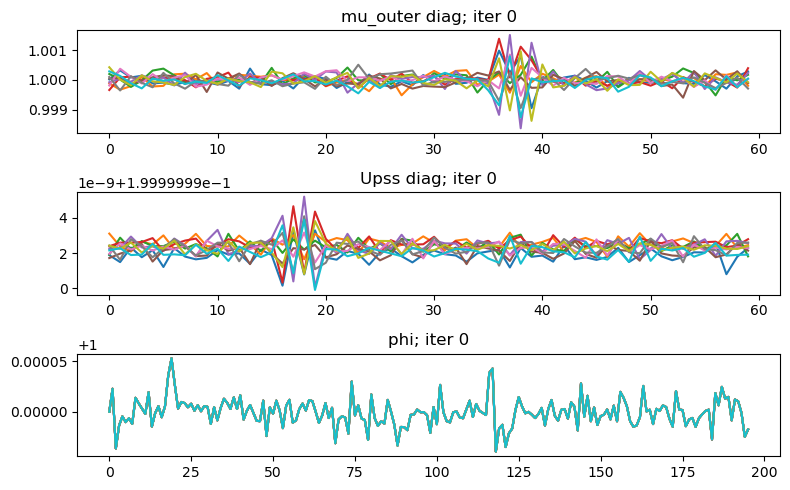

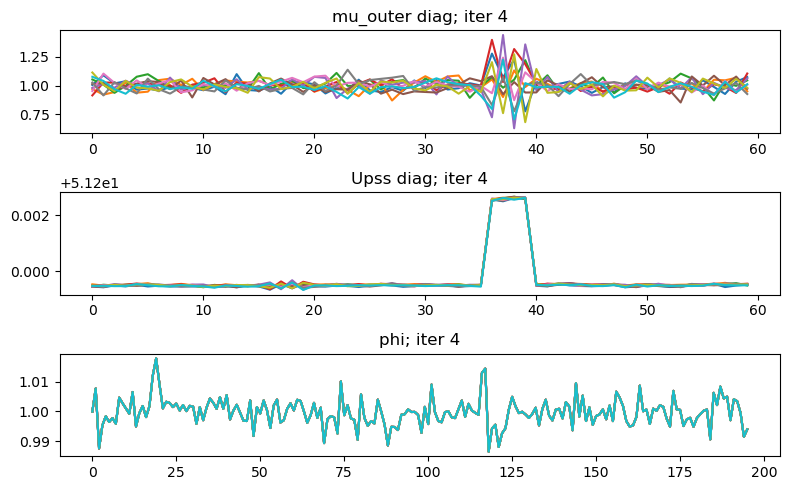

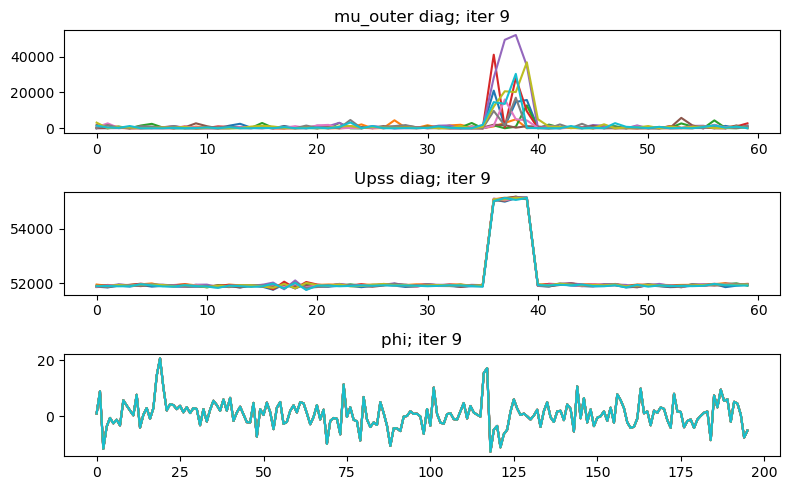

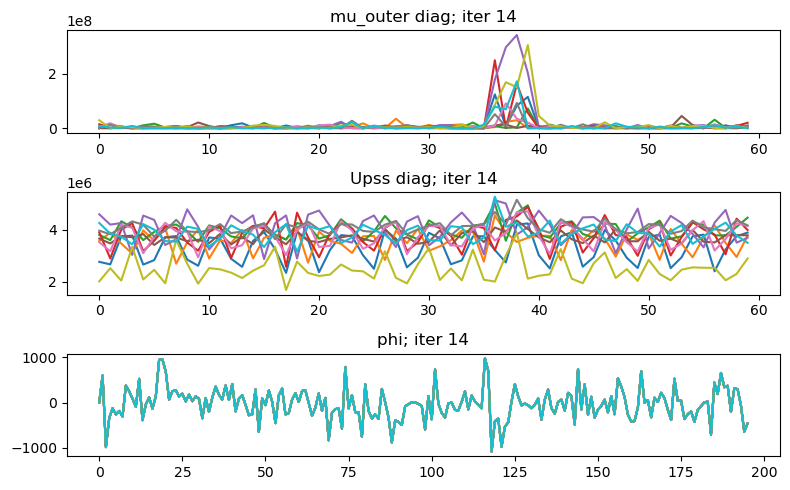

In [12]:
from cohlib.alg.em_sgc import get_freq_vecs_real
from cohlib.conv import conv_v_to_z
W = model_load['Wv']
num_J_vars = W.shape[1]
J = int(num_J_vars / 2)


Rs = [0, 4, 9, 14]

for r in Rs:
    mus = model_load['track'][0][r]['mus']
    Ups_invs = model_load['track'][0][r]['Ups_invs']
    phi = model_load['track'][0][r]['phi']


    mus_outer = np.zeros((L, J, K * 2, K * 2))
    Upss = np.zeros((L, J, K * 2, K * 2))

    for l in range(L):
        Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
            Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    fig, ax = plt.subplots(3,1,figsize=(8,5))
    for l in range(10):
        a = np.concatenate([np.diag(mus_outer[l,j,:,:]).flatten() for j in range(15)])
        b = np.concatenate([np.diag(Upss[l,j,:,:]).flatten() for j in range(15)])
        ax[0].plot(a)
        ax[0].set_title(f'mu_outer diag; iter {r}')
        ax[1].plot(b)
        ax[1].set_title(f'Upss diag; iter {r}')
        ax[2].plot(phi)
        ax[2].set_title(f'phi; iter {r}')
    plt.tight_layout()

In [14]:
from scipy.linalg import block_diag
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def update_Gamma_complex_mod(mus, Ups_invs, phi_prev, K, num_J_vars):
    """
    M-Step

    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    """
    L = mus.shape[0]

    J = int(num_J_vars / 2)
    mus_outer = np.zeros((L, J, K * 2, K * 2))
    Upss = np.zeros((L, J, K * 2, K * 2))
    mu_phis = np.zeros((L, J, K * 2, K * 2))
    mu_phis_T = np.zeros((L, J, K * 2, K * 2))
    phi_outer = np.zeros((J, K * 2, K * 2))

    # phi_prev_js = get_freq_vecs_real(phi_prev, K, num_J_vars)
    # for j in range(J):
    #     mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
    #     Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])
    #     mu_phi = np.outer(mus[l,:], phi_prev)

    phi_prev_js = get_freq_vecs_real(phi_prev, K, num_J_vars)
    for j in range(J):
        phi_outer[j,:,:] = np.outer(phi_prev_js[j], phi_prev_js[j])
    for l in range(L):
        Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
            mu_phis[l,j,:,:] = np.outer(mu_js[j], phi_prev_js[j])
            mu_phis_T[l,j,:,:] = mu_phis[l,j,:,:].T

            Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask = 1 - k_mask_inv

    Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
    Gamma_mu_update_complex = np.zeros((J, K, K), dtype=complex)
    Gamma_Sig_update_complex = np.zeros((J, K, K), dtype=complex)
    for l in range(L):
        Psi_mu_real = mus_outer[l,:,:,:]
        Psi_mu_complex = np.zeros((J, K, K), dtype=complex)

        Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
        Psi_Sig_real = Sig_real
        Psi_Sig_complex = np.zeros((J, K, K), dtype=complex)


        mu_phi = mu_phis[l,:,:,:]
        mu_phi_T = mu_phis_T[l,:,:,:]
        Psi_real = Sig_real - (mu_phi + mu_phi_T) + phi_outer
        # Sig_complex = np.zeros((J, K, K), dtype=complex)
        Psi_complex = np.zeros((J, K, K), dtype=complex)

        for j in range(J):
            Psi_mu_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_mu_real[j, :, :], K)
            )

            Psi_Sig_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_Sig_real[j, :, :], K)
            )

            Psi_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_real[j, :, :], K)
            )
        Gamma_update_complex += Psi_complex
        Gamma_mu_update_complex += Psi_mu_complex
        Gamma_Sig_update_complex += Psi_Sig_complex

    Gamma_update_complex = Gamma_update_complex / L
    Gamma_mu_update_complex = Gamma_mu_update_complex / L
    Gamma_Sig_update_complex = Gamma_Sig_update_complex / L

    return Gamma_update_complex, Gamma_mu_update_complex, Gamma_Sig_update_complex

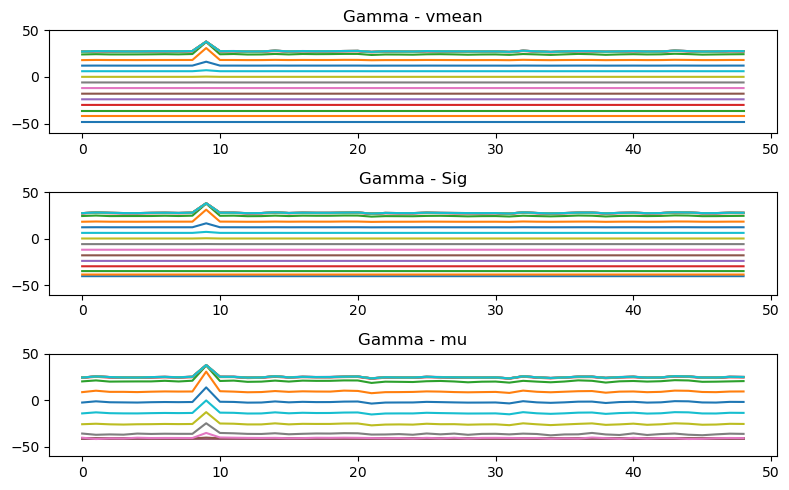

In [16]:
logS = True
delta = 1e-3
from cohlib.alg.em_sgc import get_freq_vecs_real
from cohlib.conv import conv_v_to_z
W = model_load['Wv']
num_J_vars = W.shape[1]
J = int(num_J_vars / 2)

Rs = [0, 4, 9, 14]
Rs = range(em_iters)

fig, ax = plt.subplots(3,1,figsize=(8,5))

for r in Rs:
    mus = model_load['track'][0][r]['mus']
    Ups_invs = model_load['track'][0][r]['Ups_invs']
    phi = model_load['track'][0][r]['phi']


    # mus_outer = np.zeros((L, J, K * 2, K * 2))
    # Upss = np.zeros((L, J, K * 2, K * 2))

    # for l in range(L):
    #     Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
    #     mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
    #     for j in range(J):
    #         mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
    #         Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    Gamma_vmean, Gamma_mu, Gamma_sig = update_Gamma_complex_mod(mus, Ups_invs, phi, K, num_J_vars)

    S_vmean = Gamma_vmean[:50,0,0].real
    S_vmean = S_vmean*(delta**2*(2*np.pi)**2)

    S_mu = Gamma_mu[:50,0,0].real
    S_mu = S_mu*(delta**2*(2*np.pi)**2)

    S_sig = Gamma_sig[:50,0,0].real
    S_sig = S_sig*(delta**2*(2*np.pi)**2)
    # S_true = Gamma[:50,0,0].real
    # S_oracle = Gamma_zest[:50,0,0].real
    # S_init = Gamma_init[:50,0,0].real

    # S_true = S_true*(delta**2*(2*np.pi)**2)
    # S_oracle = S_oracle*(delta**2*(2*np.pi)**2)
    # S_init = S_init*(delta**2*(2*np.pi)**2)
    if logS is True:
        S_vmean = 10*np.log10(S_vmean)
        S_mu = 10*np.log10(S_mu)
        S_sig = 10*np.log10(S_sig)

        # S_true = 10*np.log10(S_true)
        # S_naive = 10*np.log10(S_naive)
        # S_oracle = 10*np.log10(S_oracle)

    a = np.concatenate([np.diag(mus_outer[l,j,:,:]).flatten() for j in range(15)])
    b = np.concatenate([np.diag(Upss[l,j,:,:]).flatten() for j in range(15)])
    ax[0].plot(S_vmean)
    ax[0].set_title(f'Gamma - vmean')
    ax[1].plot(S_sig)
    ax[1].set_title(f'Gamma - Sig')
    ax[2].plot(S_mu)
    ax[2].set_title(f'Gamma - mu')
    ax[0].set_ylim([-60,50])
    ax[1].set_ylim([-60,50])
    ax[2].set_ylim([-60,50])
    # for l in range(10):
    #     a = np.concatenate([np.diag(mus_outer[l,j,:,:]).flatten() for j in range(15)])
    #     b = np.concatenate([np.diag(Upss[l,j,:,:]).flatten() for j in range(15)])
    #     ax[0].plot(a)
    #     ax[0].set_title(f'mu_outer diag; iter {r}')
    #     ax[1].plot(b)
    #     ax[1].set_title(f'Upss diag; iter {r}')
    #     ax[2].plot(phi)
    #     ax[2].set_title(f'phi; iter {r}')
    plt.tight_layout()


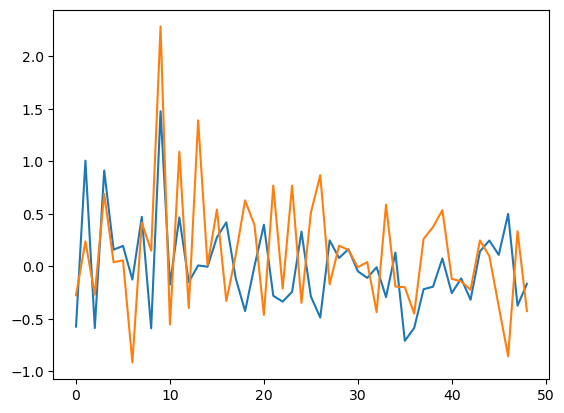

In [16]:
r = 19
k = 0
mus.shape

mu_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mu_zk = conv_v_to_z(mu_k, axis=1, dc=False)
plt.plot(np.real(mu_zk.mean(0)))
plt.plot(np.imag(mu_zk.mean(0)))
# plt.plot(np.abs(mu_zk.mean(0))**2)
# plt.plot(np.abs(mu_l))


In [17]:
mu_zk.shape

(50, 49)

In [18]:
mu_zk.shape

(50, 49)

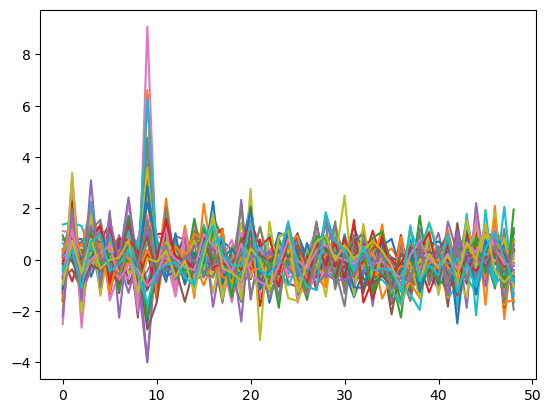

In [19]:
r = 19
k = 0
mus = model_load['track'][0][r]['mus']
mus.shape
for l in range(L):
    mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
    mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
    plt.plot(np.real(mu_zl))
# plt.plot(np.abs(mu_l))


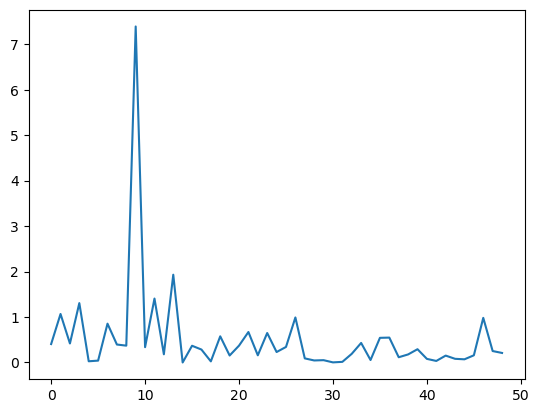

In [21]:
k = 0
mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mus_k_mean = mus_k.mean(0)
mu_zk = conv_v_to_z(mus_k_mean, axis=0, dc=False)
plt.plot(np.abs(mu_zk)**2)

ping
ping


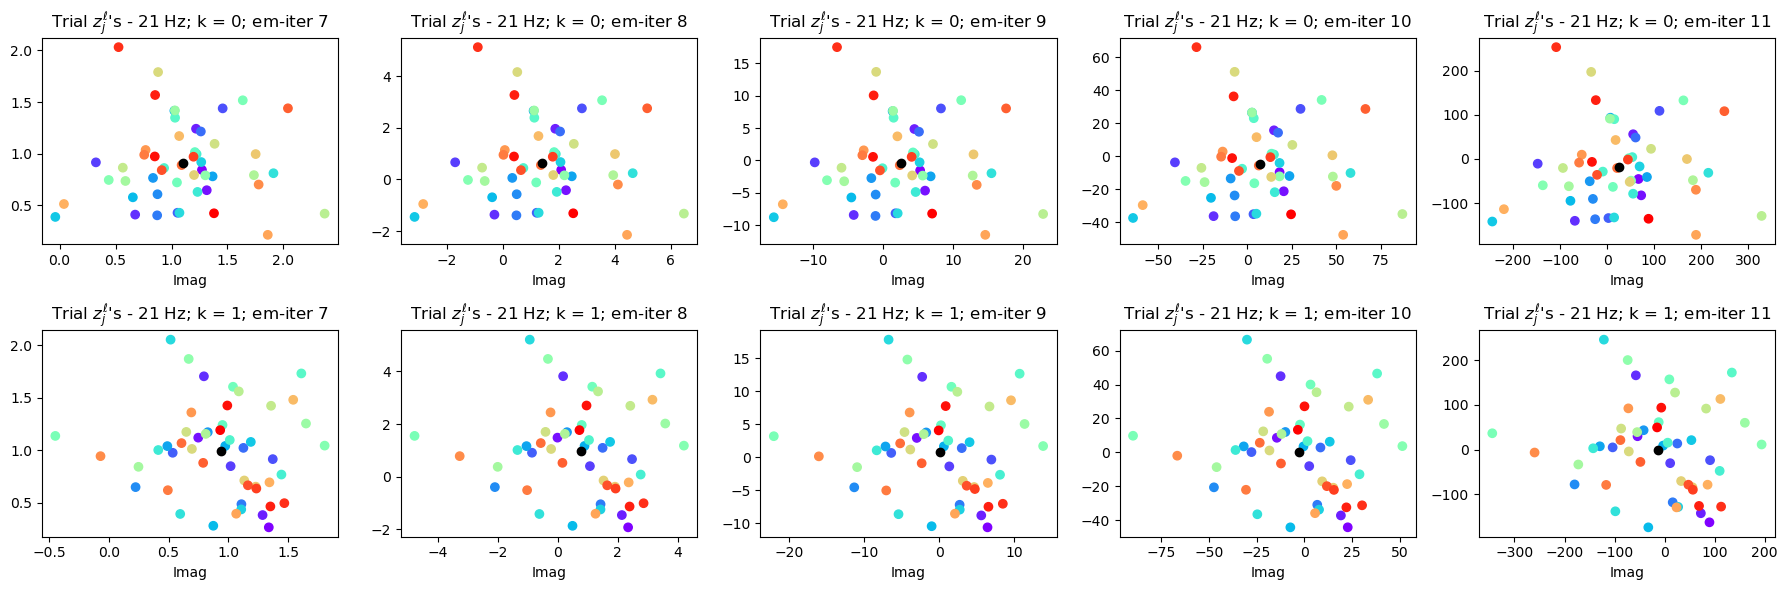

In [25]:
r = 19
k = 0
# for r in range(20):
#     mus = model_load['track'][0][r]['mus']
#     mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
#     # plt.plot(mus_zk.mean(0).real)
#     np.abs(mus_zk.mean(0))**2
#     plt.plot(np.abs(mus_zk.mean(0))**2)
j = 20
K = 2

stitr = 5
enditr = stitr+5

free_scale = True

fig, ax = plt.subplots(2,5,figsize=(18,6))
for i, r in enumerate(range(enditr, stitr, -1)):
    i = 4-i
    for k in range(K):
        mus = model_load['track'][0][r]['mus']
        mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
        color = plt.cm.rainbow(np.linspace(0, 1, L))

        ax[k,i].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
        ax[k,i].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
        # ak,x[i].set_title(r'$z_{j=5}$', f'; em-iter {r+1}')
        ax[k,i].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}; em-iter {r+1}')
        ax[k,i].set_xlabel('Real')
        ax[k,i].set_xlabel('Imag')
        if i == 4:
            print('ping')
            lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
        if free_scale is False:
            ax[k,i].set_xlim([-lim,lim])
            ax[k,i].set_ylim([-lim,lim])
plt.tight_layout()
plt.show()


# mus.shape
# for l in range(L):
#     mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
#     plt.plot(np.abs(mu_zl))

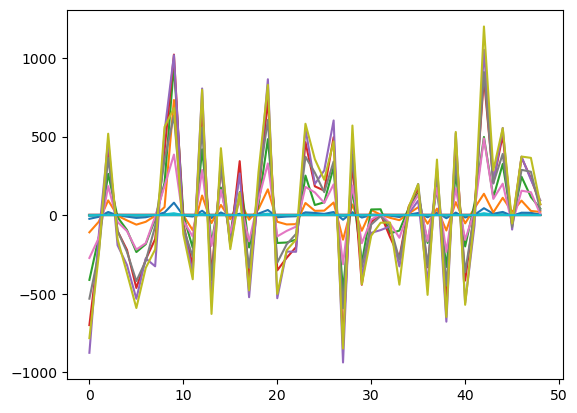

In [32]:
for r in range(20):
    mus = model_load['track'][0][r]['mus']
    mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
    mus_zk_mean = mus_zk.mean(0)
    plt.plot(mus_zk_mean.real)
    # plt.plot(mus_zk_mean.imag)

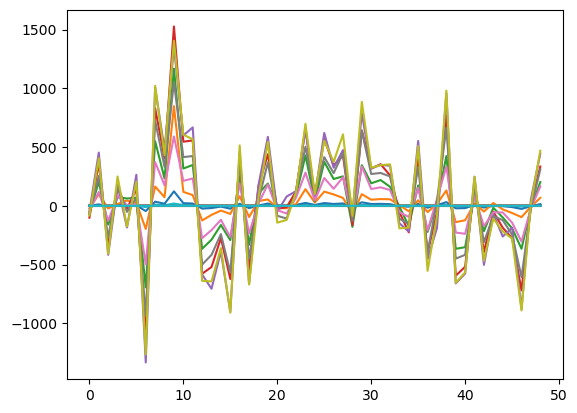

In [33]:
for r in range(20):
    mus = model_load['track'][0][r]['mus']
    mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
    mus_zk_mean = mus_zk.mean(0)
    plt.plot(mus_zk_mean.imag)

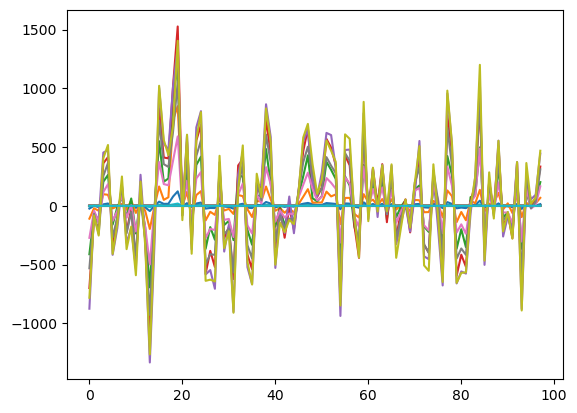

In [31]:
for r in range(20):
    mus = model_load['track'][0][r]['mus']
    mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    mus_k_mean = mus_k.mean(0)
    plt.plot(mus_k_mean)

In [1]:
for r in range(20):
    phi = model_load['track'][0][r]['phi']
    phi_k = phi[k*num_J_vars:k*num_J_vars+num_J_vars]
    plt.plot(phi_k)

NameError: name 'model_load' is not defined

350.0


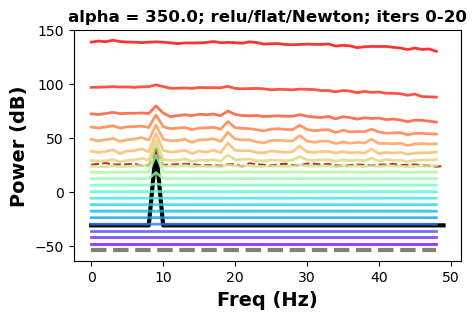

In [63]:
plot_res_S('relu', 'flat', 'Newton', 350.0, True, [0,20])

350.0


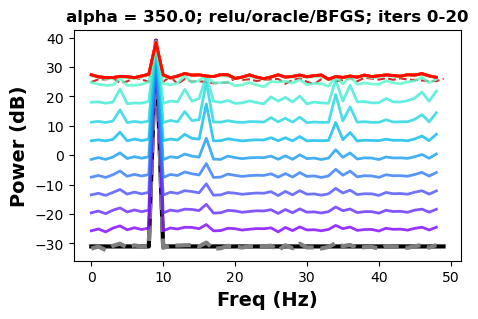

In [64]:
plot_res_S('relu', 'oracle', 'BFGS', 350.0, True, [0,20])

350.0


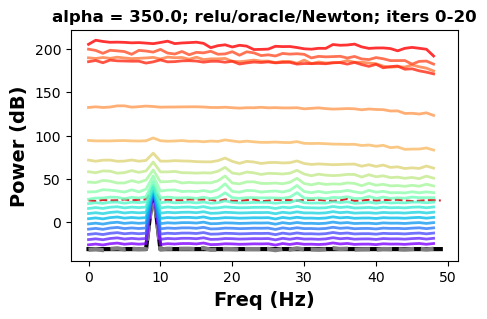

In [65]:
plot_res_S('relu', 'oracle', 'Newton', 350.0, True, [0,20])

In [27]:
spikes[:,0,0,:].mean()

0.34596

In [96]:
from cohlib.utils import (
    transform_cov_r2c,
    rearrange_mat,
)
from scipy.linalg import block_diag
def get_freq_vecs_real(vec, K, num_J_vars):
    """
    Un-vectorize over frequencies.
    """
    j_vecs = []
    for jv in range(0, num_J_vars, 2):
        base_filt = np.zeros(num_J_vars)
        base_filt[jv : jv + 2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs

def update_Gamma_complex_mu_only(mus, K, num_J_vars):
    """
    M-Step

    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    """
    L = mus.shape[0]

    J = int(num_J_vars / 2)
    mus_outer = np.zeros((L, J, K * 2, K * 2))

    for l in range(L):
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask = 1 - k_mask_inv

    Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
    for l in range(L):
        Sig_real = mus_outer[l, :, :, :] * k_mask 
        Sig_complex = np.zeros((J, K, K), dtype=complex)
        for j in range(J):
            Sig_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Sig_real[j, :, :], K)
            )
        Gamma_update_complex += Sig_complex
    Gamma_update_complex = Gamma_update_complex / L

    return Gamma_update_complex

In [106]:
emiter = 2
alpha = float(alpha)
model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
model_load = pickle_open(model_path)

mus_temp = model_load['track'][0][emiter]['mus']
gamma_temp = model_load['track'][0][emiter]['gamma']
Gamma = data_load['latent']['Gamma']
gamma_mus = update_Gamma_complex_mu_only(mus_temp, K, num_J_vars)

In [107]:
gamma_mus.shape

(49, 2, 2)

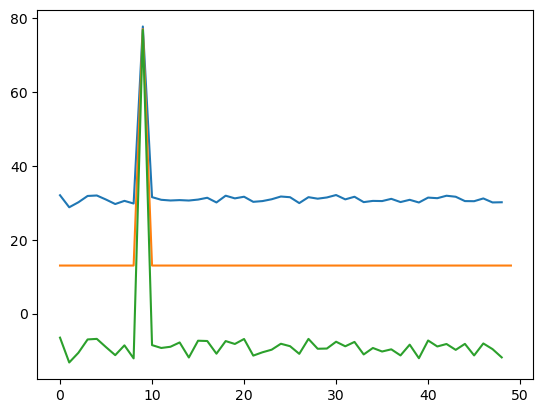

In [108]:
plt.plot(10*np.log10(gamma_temp[:50,0,0].real))
plt.plot(10*np.log10(Gamma[:50,0,0].real))
plt.plot(10*np.log10(gamma_mus[:50,0,0].real))

In [111]:
test = dict(abc="123")
test.get('bc', False)

False

50
50
50
50


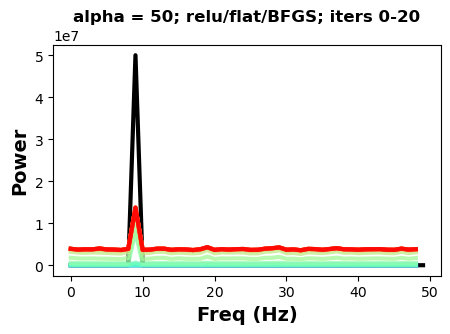

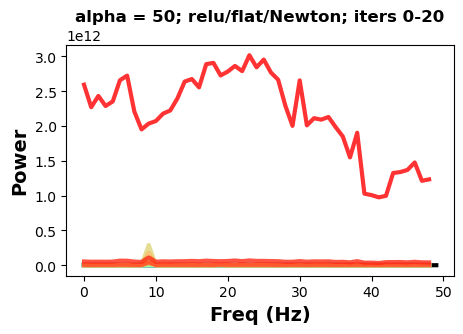

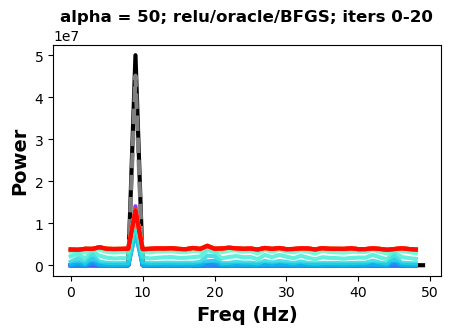

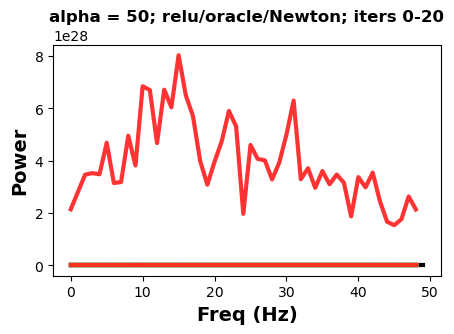

In [136]:
alpha = 50
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = False
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

200
200
200
200
200
200
200
200


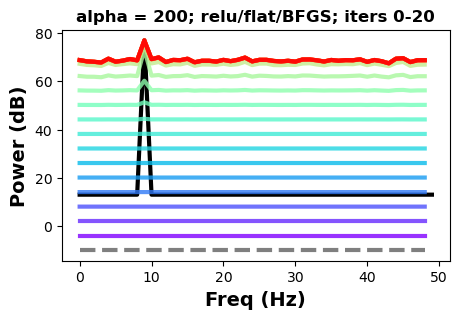

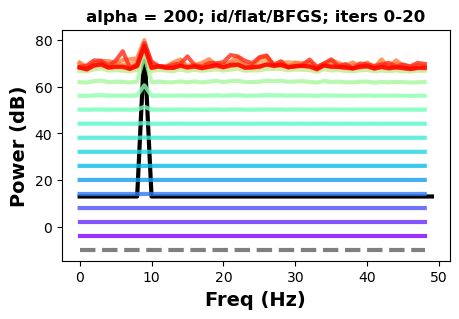

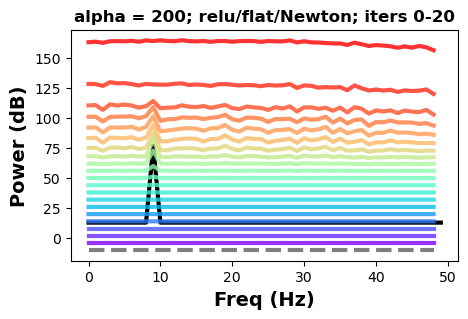

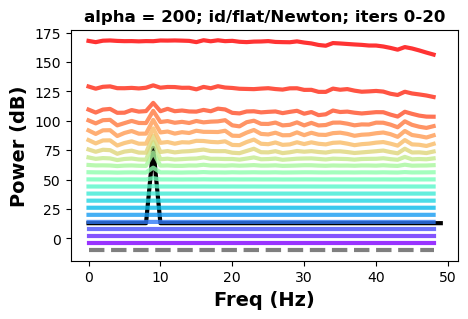

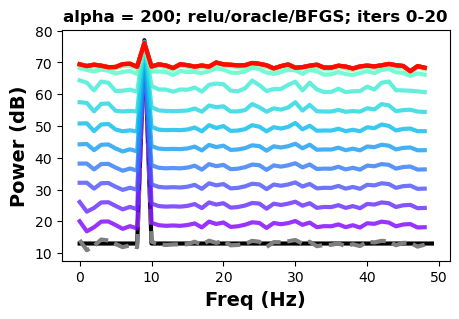

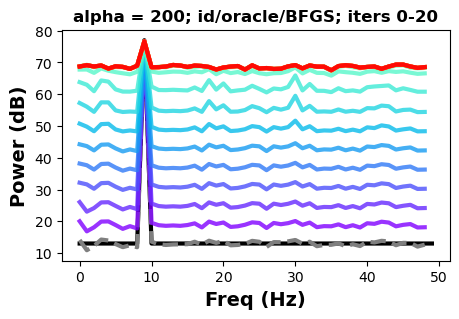

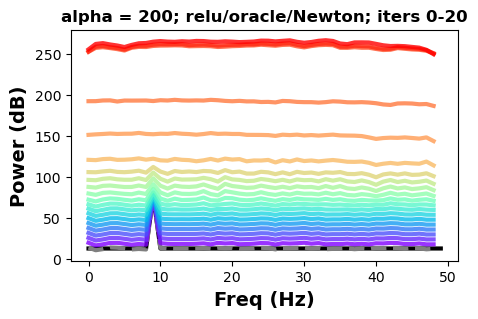

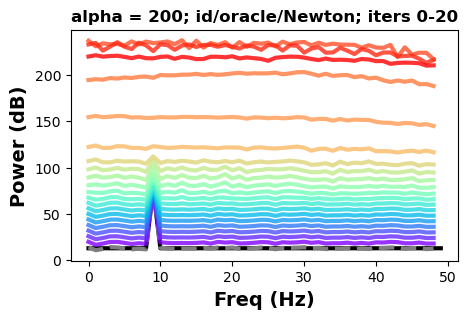

In [63]:
alpha = 200
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = True
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

500
500
500
500
500
500
500
500


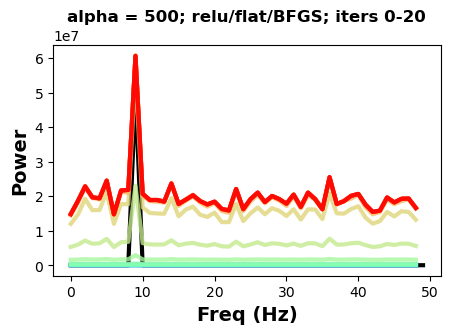

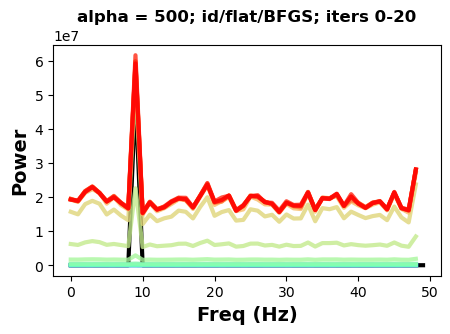

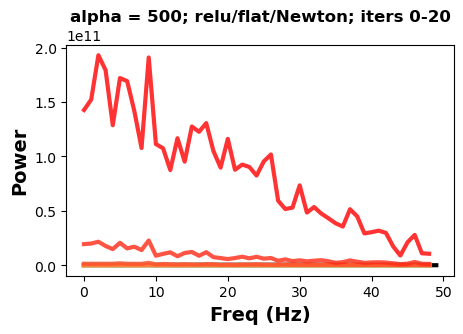

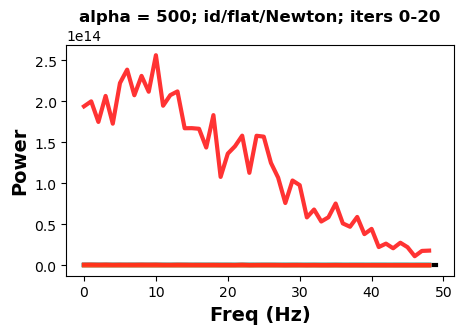

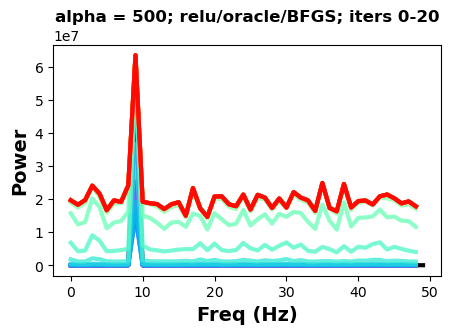

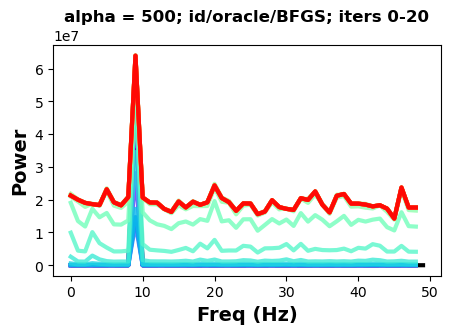

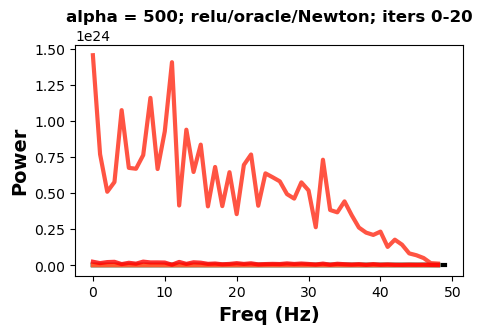

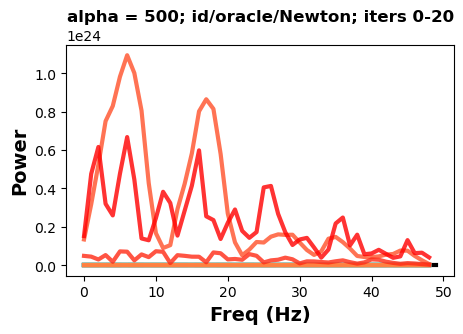

In [137]:
alpha = 500
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = False
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

1000
1000
1000
1000
1000
1000
1000
1000


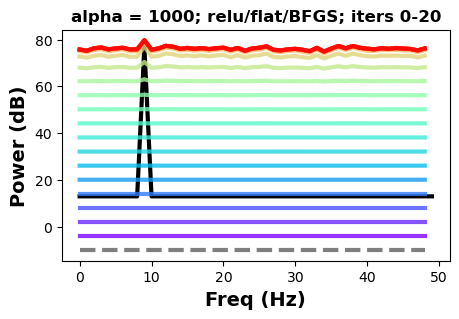

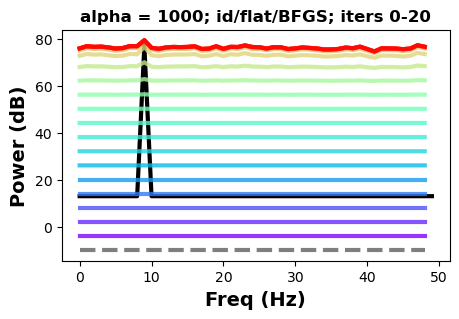

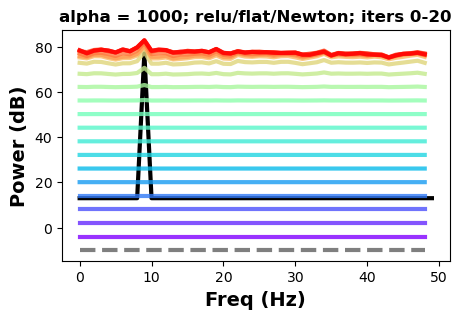

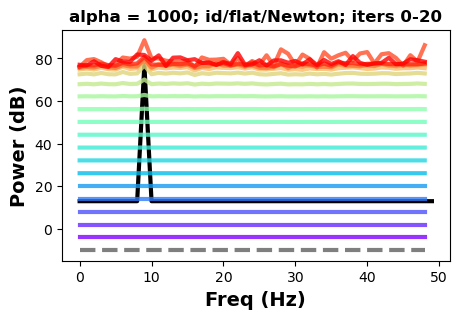

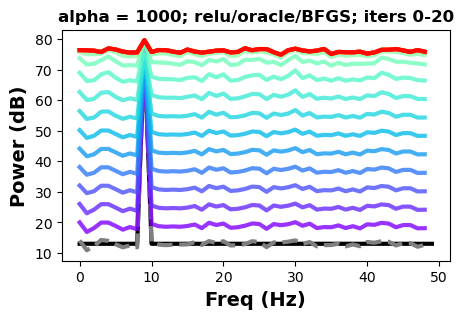

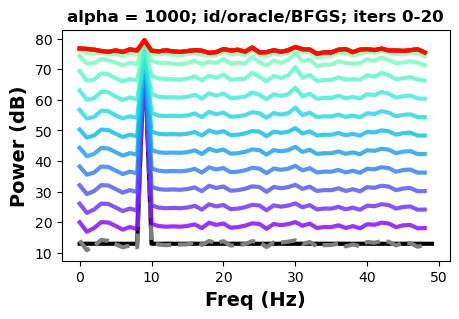

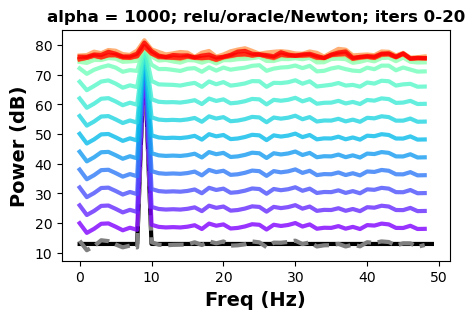

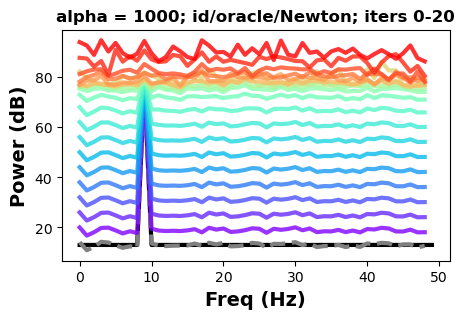

In [65]:

alpha = 1000
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = True
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

2000


Text(0.5, 0, 'Freq (Hz)')

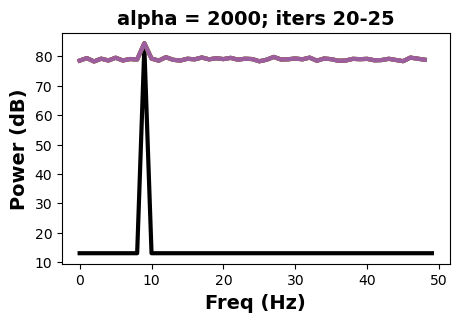

In [12]:
fig, ax = plt.subplots(figsize=(5,3))
alpha = 2000
i = 0

track = np.array([0,5])
track += 20


print(alpha)
logS = True
alpha_dict = get_alpha_data(alpha, logS, track=track)
S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_naive = alpha_dict['S']['naive']


# coh_true = alpha_dict['coh']['true']
# coh_oracle = alpha_dict['coh']['oracle']
# coh_model = alpha_dict['coh']['model']
# coh_naive = alpha_dict['coh']['naive']

ax.plot(S_true, color='k', label='true', linewidth=3)
# ax.plot(S_oracle, color='tab:green', label='direct')
# ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')

if track is None:
    S_model = alpha_dict['S']['model']
    ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
    ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
else:
    S_model_list = alpha_dict['S']['model']
    for e in range(len(S_model_list)):
        ax.plot(S_model_list[e], linewidth=3, alpha=0.8)
    ax.set_title(f'alpha = {alpha}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=14)

if logS is False:
    ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
else:
    ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
# if k == 3:
    # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
    # ax[i1,i2].set_ylim([low, 1])
# ax.set_ylim([1e4,1e8])

In [34]:
len(S_model_list)

5

In [28]:
len(S_model_list)

14

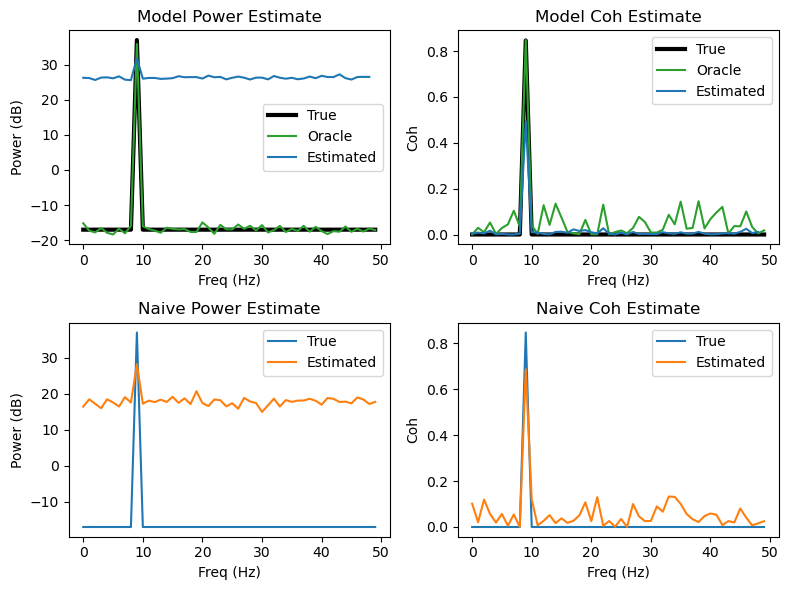

In [11]:
alphas = [2.5, 3.0, 3.5, 4.0, 4.5]

logS = True
alpha_dict = get_alpha_data(alpha, logS)
S_true = alpha_dict['S']['true']
S_oracle = alpha_dict['S']['oracle']
S_model = alpha_dict['S']['model']
S_naive = alpha_dict['S']['naive']

coh_true = alpha_dict['coh']['true']
coh_oracle = alpha_dict['coh']['oracle']
coh_model = alpha_dict['coh']['model']
coh_naive = alpha_dict['coh']['naive']

fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].plot(S_true, label='True', color='k', linewidth=3)
ax[0,0].plot(S_oracle, label='Oracle', color='tab:green')
ax[0,0].plot(S_model, label='Estimated')
ax[0,0].set_xlabel('Freq (Hz)')
ax[0,0].set_title('Model Power Estimate')
ax[0,1].plot(coh_true, label='True', color='k', linewidth=3)
ax[0,1].plot(coh_oracle, label='Oracle', color='tab:green')
ax[0,1].plot(coh_model, label='Estimated')
ax[0,1].set_ylabel('Coh')
ax[0,1].set_xlabel('Freq (Hz)')
ax[0,1].set_title('Model Coh Estimate')
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(S_true, label='True')
ax[1,0].plot(S_naive[0,:], label='Estimated')
ax[1,0].set_xlabel('Freq (Hz)')
ax[1,0].set_title('Naive Power Estimate')
ax[1,1].plot(coh_true , label='True')
ax[1,1].plot(coh_naive, label='Estimated')
ax[1,1].set_ylabel('Coh')
ax[1,1].set_xlabel('Freq (Hz)')
ax[1,1].set_title('Naive Coh Estimate')
ax[1,0].legend()
ax[1,1].legend()

if logS is True:
    ax[0,0].set_ylabel('Power (dB)')
    ax[1,0].set_ylabel('Power (dB)')
else:
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
plt.tight_layout()

Text(0.5, 1.0, 'Firing Rates')

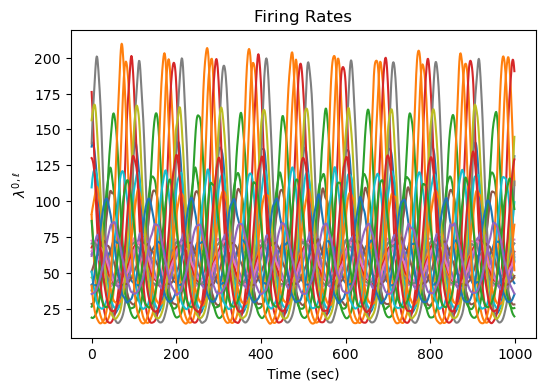

In [12]:
time = np.arange(1000)*1e-3
lams.shape
fig, ax = plt.subplots(figsize=(6,4))
for l in range(L):
    ax.plot(lams[l,0,:])
ax.set_xlabel('Time (sec)')
ax.set_ylabel(r'$\lambda^{0,\ell}$')
ax.set_title('Firing Rates')


In [13]:
from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence
# spikes_mc = (spikes[:L,:C,0,:] - spikes[:L,:C,0,:].mean(2)[:,:,None]).mean(1)
# spikes_mc = spikes
spikes_mc = spikes.mean(1)
# ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
S_naive = S_naive[:,1:51]

ft_spikes0 = ft_spikes[:,0,1:]
ft_spikes1 = ft_spikes[:,1,1:]

coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
coh_naive = coh_naive[:50]

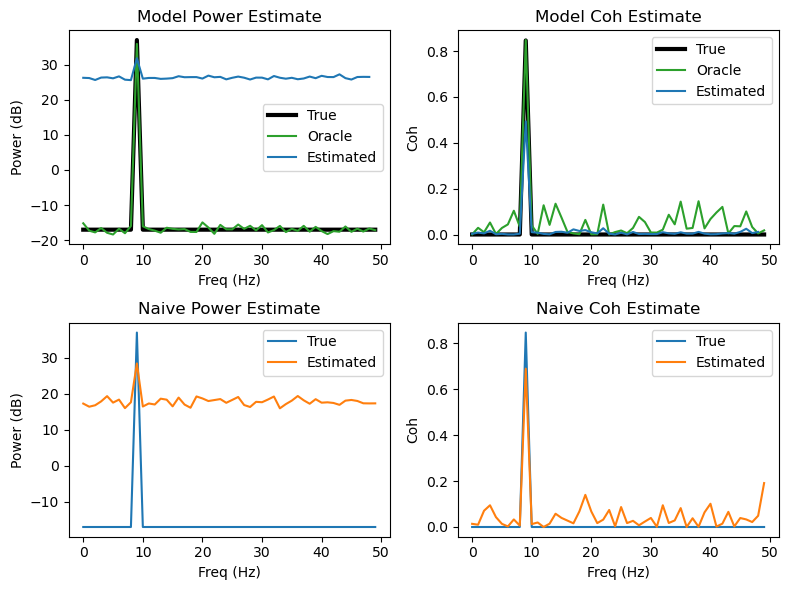

In [14]:
coh_true = thr_coherence(Gamma[:50,:,:])
coh_model = thr_coherence(Gamma_est[:50,:,:])
coh_oracle = thr_coherence(Gamma_zest[:50,:,:])

S_true = Gamma[:50,0,0].real
S_model = Gamma_est[:50,0,0].real
S_oracle = Gamma_zest[:50,0,0].real

logS = True

if logS is True:
    S_true = 10*np.log10(S_true)
    S_model = 10*np.log10(S_model)
    S_naive = 10*np.log10(S_naive)
    S_oracle = 10*np.log10(S_oracle)

fig, ax = plt.subplots(2,2, figsize=(8,6))
ax[0,0].plot(S_true, label='True', color='k', linewidth=3)
ax[0,0].plot(S_oracle, label='Oracle', color='tab:green')
ax[0,0].plot(S_model, label='Estimated')
ax[0,0].set_xlabel('Freq (Hz)')
ax[0,0].set_title('Model Power Estimate')
ax[0,1].plot(coh_true, label='True', color='k', linewidth=3)
ax[0,1].plot(coh_oracle, label='Oracle', color='tab:green')
ax[0,1].plot(coh_model, label='Estimated')
ax[0,1].set_ylabel('Coh')
ax[0,1].set_xlabel('Freq (Hz)')
ax[0,1].set_title('Model Coh Estimate')
ax[0,0].legend()
ax[0,1].legend()

ax[1,0].plot(S_true, label='True')
ax[1,0].plot(S_naive[0,:], label='Estimated')
ax[1,0].set_xlabel('Freq (Hz)')
ax[1,0].set_title('Naive Power Estimate')
ax[1,1].plot(coh_true , label='True')
ax[1,1].plot(coh_naive, label='Estimated')
ax[1,1].set_ylabel('Coh')
ax[1,1].set_xlabel('Freq (Hz)')
ax[1,1].set_title('Naive Coh Estimate')
ax[1,0].legend()
ax[1,1].legend()

if logS is True:
    ax[0,0].set_ylabel('Power (dB)')
    ax[1,0].set_ylabel('Power (dB)')
else:
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
plt.tight_layout()

In [165]:
freqstrt = 0
freqend = 50
def plot_itrs(itrstart, itrend):
    spikes_mc = spikes.mean(1)
    ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[:,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[freqstrt:freqend]
    fig, ax = plt.subplots(2,2, figsize=(6,5))
    # itr = 2
    for i, itr in enumerate(range(itrstart,itrend)):
        # print(i+1)
    # for itr in range(10):
        Gamma_est_itr = model_load['track'][0][itr-1]['gamma']

        S_true = Gamma[freqstrt:freqend,0,0].real
        S_model = Gamma_est_itr[freqstrt:freqend,0,0].real

        coh_true = thr_coherence(Gamma[freqstrt:freqend,:,:])
        coh_model = thr_coherence(Gamma_est_itr[freqstrt:freqend,:,:])

        logS = False

        if logS is True:
            S_true = 10*np.log10(S_true)
            S_model = 10*np.log10(S_model)
            S_naive = 10*np.log10(S_naive)

        if i == 0:
            ax[0,0].plot(S_true, label='True', color='k')
            ax[0,1].plot(coh_true, color='k')
        if i < 10:
            ax[0,0].plot(S_model, label='Estimated')
        else:
            ax[0,0].plot(S_model)
        ax[0,1].plot(coh_model)
        ax[0,0].set_ylabel('Power')
        ax[0,0].set_xlabel('Freq (Hz)')
        ax[0,0].set_title('Model Power Estimate')
        ax[0,1].set_ylabel('Coh')
        ax[0,1].set_xlabel('Freq (Hz)')
        ax[0,1].set_title('Model Coh Estimate')
        ax[0,0].legend()
        # ax[0,1].legend()

    ax[1,0].plot(S_true, label='True', color='k')
    ax[1,0].plot(S_naive[0,:], label='Estimated')
    ax[1,0].set_ylabel('Power')
    ax[1,0].set_xlabel('Freq (Hz)')
    ax[1,0].set_title('Naive Power Estimate')
    ax[1,1].plot(coh_true , label='True', color='k')
    ax[1,1].plot(coh_naive, label='Estimated')
    ax[1,1].set_ylabel('Coh')
    ax[1,1].set_xlabel('Freq (Hz)')
    ax[1,1].set_title('Naive Coh Estimate')
    if itr==0:
        ax[1,0].legend()
        ax[1,1].legend()
    plt.tight_layout()

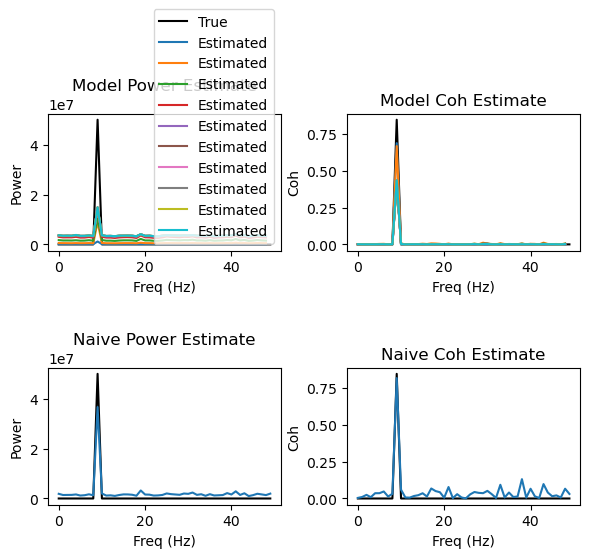

In [166]:
plot_itrs(10,20)

/projectnb/stephenlab/jtauber/cohlib/cohlib/mvcn.py:214: RuntimeWarning: invalid value encountered in divide
  t_coh = num/denom


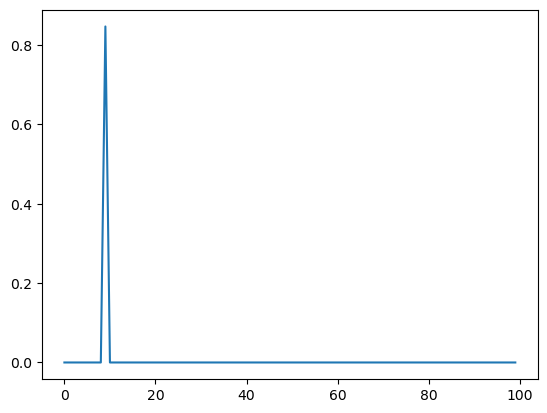

In [19]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
Gamma_inv_init = model_load['inv_init']
J = Gamma_est.shape[0]

Gamma_init = deconstruct_Gamma_full_real(Gamma_inv_init, K, 2*J, invert=True)

# plt.plot(Gamma_init[:,0,0].real)
# plt.plot(Gamma_zest[:50,0,0].real)

In [15]:
Gamma[:,0,0].real

array([5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+07, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03, 5.e+03,
       5.e+03, 5.e+03, 5.e+03, 5.e+03, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
      

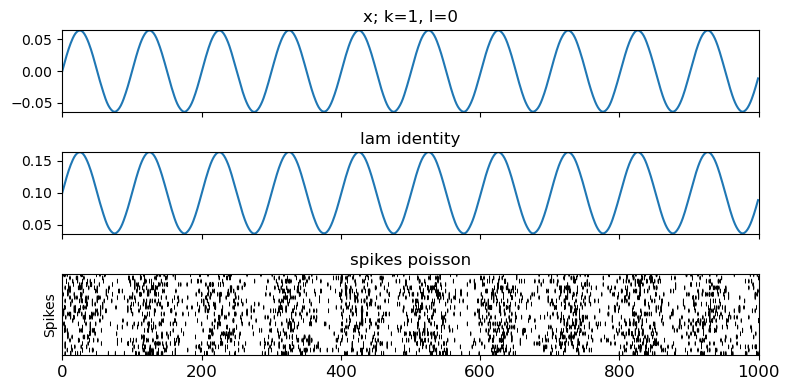

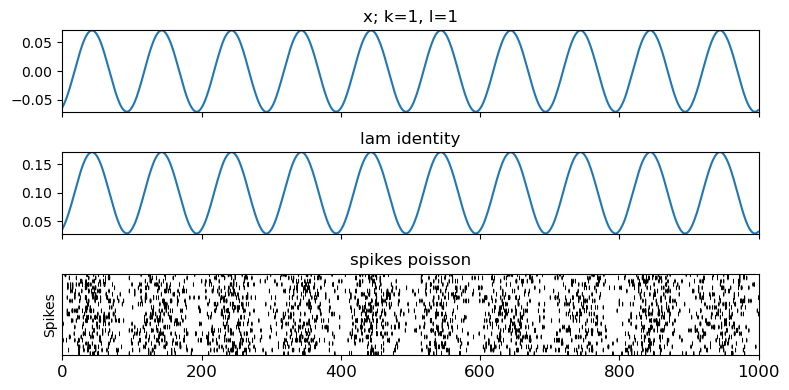

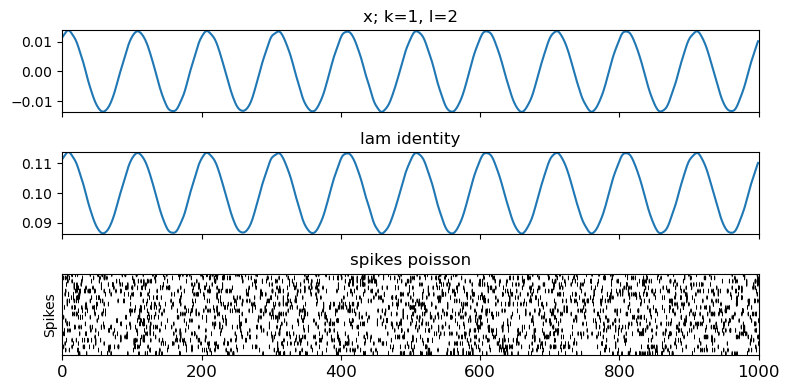

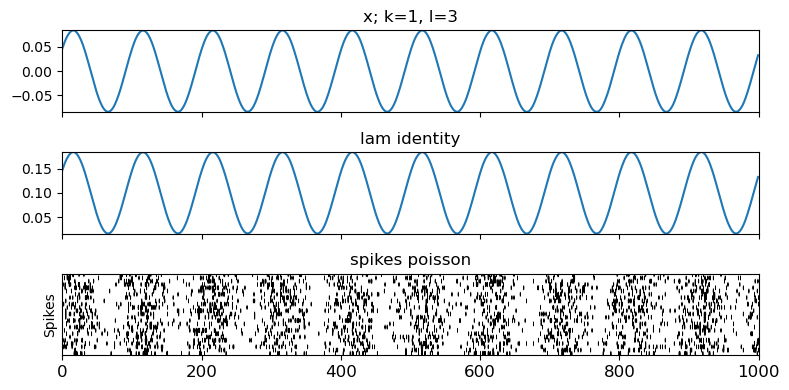

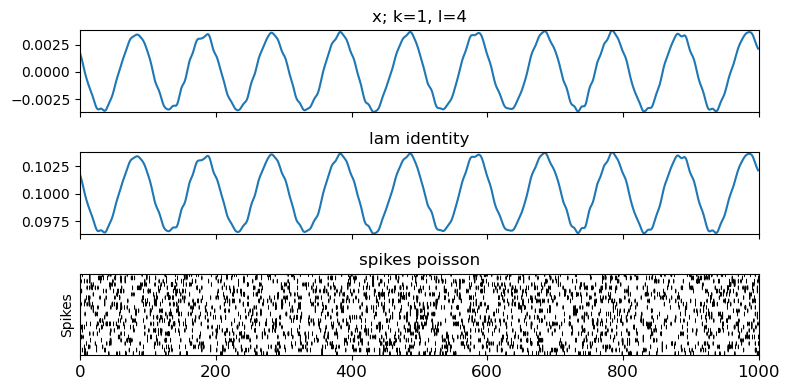

In [98]:
k = 1
l = 0
for l in range(5):
    fig, ax = plt.subplots(3,1,figsize=(8,4), sharex=True)
    ax[0].plot(xs[l,k,:])
    ax[0].set_title(f'x; k={k}, l={l}')
    ax[1].plot(lams[l,k,:])
    ax[1].set_title(f'lam identity')
    draw_raster_single(spikes[l,:,k,:], trange=[0,1000], ax = ax[2])
    ax[2].set_title(f'spikes poisson')
    ax[0].margins(0)
    ax[1].margins(0)

    plt.tight_layout()